# Multi - Patient Script v1

## TDT Pipeline - Peter Yazdi

Welcome to the Multi Patient Script v1. This will be taking the TDT pipeline as of v1 and analyze the output folders of your choice (note will go through Multiple patient outputs). For this script to work accurately, please download correct dependencies and run whole script. If you want to analyze single patient, use the single patient script. 

For any concerns/help please email pyazdi@bbcrc.ca

## Imports 

In [50]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
from json_minify import json_minify
import json
import numpy as np
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
# ----------------------------
# Global styling (recommended)
# ----------------------------
mpl.rcParams.update({
    "font.size": 18,              # base size
    "font.weight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 22,
    "figure.titlesize": 26,
    "figure.titleweight": "bold",
    "axes.labelweight": "bold",
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})


classes = {
    "0": "background",
    "1": "body",
    "2": "kidney",
    "3": "liver",
    "4": "prostate",
    "5": "spleen",
    "6": "heart",
    "7": "salivary_glands"
}

## User adjustable parameters

In [51]:
show_results = False # Set to True to display the results

current_folder = os.getcwd()
output_folder_dir = os.path.join(current_folder, "20_patient_dataset_feb_2026")
output_folder_prefix = "TDT_Output__"

output_folders = []
config_files = []
logging_files = []
ct_paths = []

for item in os.listdir(output_folder_dir):
    if item.startswith(output_folder_prefix) and os.path.isdir(os.path.join(output_folder_dir, item)):
        output_folders.append(os.path.join(output_folder_dir, item))
output_folders.sort(key=lambda p: int(os.path.basename(p).split("CT_")[-1])) # sort in numerical order


num_patients = len(output_folders)


for out in output_folders: 
    for item in os.listdir(os.path.join(output_folder_dir, out)):
        if item.endswith(".json"):
            config_path = os.path.join(output_folder_dir, out, item)
            config_files.append(config_path)
        if item.endswith(".log"):
            logging_path = os.path.join(output_folder_dir, out, item)
            logging_files.append(logging_path)
        if item.startswith("PSMA"): # assuming CT files always start with PSMA
            ct_path = os.path.join(output_folder_dir, out, item)
            ct_paths.append(ct_path)    

if show_results:
    print("Current folder:", current_folder)
    print(f"Number of patients found: {num_patients}")
    print("Found output folders:")
    for i, out in enumerate(output_folders):
        print("Output folder:", out)
        print("  Config file:", config_files[i])
        print("  Logging file:", logging_files[i])
        print("  CT DICOM path:", ct_paths[i])



## CT Images 

In [52]:
show_plot = False # set to True to visualize CT mid slices
if show_plot:
    for i,ct in enumerate(ct_paths):
        # will plot 3 images : one for each axis
        figure, ax = plt.subplots(1,3, figsize= (20,5))
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(ct)
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        array = sitk.GetArrayFromImage(image)[::-1]  # z, y, x
        figure.suptitle(f"Patient {i+1} CT mid slices", fontsize=20, fontweight='bold')
        ax[0].set_title('Axial slice', fontsize=18, fontweight='bold')
        ax[1].set_title('Coronal slice', fontsize=18, fontweight='bold')
        ax[2].set_title('Sagittal slice', fontsize=18, fontweight='bold')
        ax[0].imshow(array[array.shape[0]//2,:,:], cmap='gray',aspect='auto')
        ax[1].imshow(array[:,array.shape[1]//2,:], cmap='gray',aspect='auto')
        ax[2].imshow(array[:,:,array.shape[2]//2], cmap='gray',aspect='auto')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()
    

## ATN Map and Activity Maps

In [53]:
show_results = False # Set to True to display the results

shape = None     # set to something (non-None) if you want to skip computing
spacing = None   # set to something (non-None) if you want to skip computing

if shape is None or spacing is None:
    shape_list = []
    spacing_list = []

    for i, output_folder in enumerate(output_folders):
        with open(config_files[i], encoding="utf-8") as f:
            config = json.loads(json_minify(f.read()))

        # ---- config fields ----
        spect_subdir = config["subdir_names"]["spect_preprocessing"]
        sp = config["spect_preprocessing"]
        prefix = sp["name"]
        xy_dim = sp.get("xy_dim", None)  # could be None

        # ---- reference image path ----
        ref_img_path = os.path.join(
            output_folder,
            spect_subdir,
            f"{prefix}_tdt_roi_seg.nii.gz"
        )
        if not os.path.exists(ref_img_path):
            raise FileNotFoundError(f"Missing ref image: {ref_img_path}")

        ref_img = sitk.ReadImage(ref_img_path)

        # SITK size/spacing are in (x,y,z)
        size_xyz = np.array(ref_img.GetSize(), dtype=float)
        spacing_xyz = np.array(ref_img.GetSpacing(), dtype=float)  # typically mm

        # Convert size to array-order (z,y,x) like sitk.GetArrayFromImage would give
        shape_zyx = np.array([size_xyz[2], size_xyz[1], size_xyz[0]], dtype=float)

        # If no resize, scale=1
        if xy_dim is None:
            scale = 1.0
        else:
            scale = float(xy_dim) / float(shape_zyx[1])  # match your pipeline: scale based on Y

        # Post-zoom shape in (z,y,x)
        new_shape_zyx = tuple(np.round(shape_zyx * scale).astype(int).tolist())

        # Post-zoom spacing: spacing / scale
        new_spacing_xyz_mm = spacing_xyz / scale

        # Reorder to (z,y,x) and convert mm -> cm
        new_spacing_zyx_cm = tuple((new_spacing_xyz_mm[[2, 1, 0]] * 0.1).tolist())

        shape_list.append(new_shape_zyx)
        spacing_list.append(new_spacing_zyx_cm)
        if show_results:
            print(
                f"{os.path.basename(output_folder)} | scale={scale:.4f} "
                f"| shape_zyx={new_shape_zyx} | spacing_zyx_cm={new_spacing_zyx_cm}"
            )

    if shape is None:
        shape = shape_list
    if spacing is None:
        spacing = spacing_list



In [54]:
show_results = False # Set to True to display the results

atn_map = []
act_map = {}

for i, output_folder in enumerate(output_folders):
    with open(config_files[i], encoding="utf-8") as f:
        config = json.loads(json_minify(f.read())) # Load configuration file
    
    subdir_name = config['subdir_names']
    frames = config['pbpk']['FrameStartTimes']
    
    spect_preprocessing_parameters = config['spect_preprocessing']
    pbpk_parameters = config['pbpk']
    
    atn_map_path = os.path.join(output_folder, subdir_name['spect_preprocessing'],f"{spect_preprocessing_parameters['name']}_atn_av.bin")
    atn_map.append(atn_map_path)
    
    act_map[i] = {}
    for f in frames:
        activity_map_path_single_frame = os.path.join(output_folder, subdir_name['pbpk'],f"{pbpk_parameters['name']}_{f}_act_av.bin")
        act_map[i][f] = activity_map_path_single_frame
    
    if show_results:
        print(f"Patient {i+1}:")
        print("  Attenuation map path:", atn_map_path)
        print("  Exists:", os.path.exists(atn_map_path))
        print("Activity maps:")
        for f in frames:
            print(f"  Frame {f}:", act_map[i][f])
            print(f"    Exists: {os.path.exists(act_map[i][f])}")
            
        print("-----")
        
        


In [55]:
show_plot = False # set to True to visualize attenuation and activity maps
if show_plot:
    for patient in range(num_patients):
        fig, ax = plt.subplots(1, 1 + len(frames), figsize=((1 + len(frames)) * 8, 8))
        ax = np.atleast_1d(ax)

        fig.suptitle(f"Patient {patient+1} Attenuation and Activity Maps",
                    fontsize=20, fontweight="bold")

        # --- Attenuation map ---
        atn_img = np.fromfile(atn_map[patient], dtype=np.float32).reshape(shape[patient])[::-1]
        ax[0].set_title("Attenuation map", fontsize=18, fontweight="bold")
        ax[0].imshow(atn_img[:, atn_img.shape[1] // 2, :], cmap="gray", aspect="auto")
        ax[0].axis("off")

        # --- One common scale for ALL activity frames (per patient) ---
        vmax = 0.0
        for f in frames:
            act_img = np.fromfile(act_map[patient][f], dtype=np.float32).reshape(shape[patient])[::-1]
            proj = np.max(act_img, axis=1)
            vmax = max(vmax, float(np.nanmax(proj)))

        vmin = 0.0
        if vmax <= vmin or not np.isfinite(vmax):
            vmax = vmin + 1e-6

        # --- Plot activity maps with shared vmin/vmax ---
        im = None
        for i, f in enumerate(frames):
            act_img = np.fromfile(act_map[patient][f], dtype=np.float32).reshape(shape[patient])[::-1]
            proj = np.max(act_img, axis=1)

            ax[i + 1].set_title(f"Activity map - Frame {f}", fontsize=18, fontweight="bold")
            im = ax[i + 1].imshow(proj, cmap="turbo", aspect="auto", vmin=vmin, vmax=vmax)
            ax[i + 1].axis("off")

        # --- One shared colorbar for all activity maps ---
        cbar = fig.colorbar(im, ax=ax[1:], fraction=0.046, pad=0.04)
        cbar.set_label("MBq/ml", fontsize=14, fontweight="bold")

        plt.show()


## Plot Recon SPECT images

In [56]:
# --- build paths ---
recon_spect_paths = {}
for i, output_folder in enumerate(output_folders):
    with open(config_files[i], encoding="utf-8") as f:
        config = json.loads(json_minify(f.read()))

    subdir_name = config["subdir_names"]
    frames_i = config["pbpk"]["FrameStartTimes"]
    sim_name = config["spect_simulation"]["name"]

    recon_spect_paths[i] = {}
    for f in frames_i:
        recon_spect_paths[i][f] = os.path.join(
            output_folder,
            subdir_name["spect_simulation"],
            f"{sim_name}_{f}min.nii" 
        )


In [57]:
show_plot = False  # set to True to visualize reconstructed SPECT images
if show_plot:
    # --- plot with shared colorbar per patient ---
    for key in recon_spect_paths.keys():
        frames_k = recon_spect_paths[key].keys()

        fig, ax = plt.subplots(1, len(frames_k), figsize=(len(frames_k) * 8, 8))
        ax = np.atleast_1d(ax)
        fig.suptitle(f"Patient {key+1} Reconstructed SPECT Image", fontsize=20, fontweight="bold")

        # compute shared vmax for this patient (shared scale across all frames)
        vmax = 0.0
        for f in frames_k:
            path = recon_spect_paths[key][f]
            if not os.path.exists(path):
                continue
            arr = sitk.GetArrayFromImage(sitk.ReadImage(path))[::-1]
            proj = np.max(arr, axis=1)
            vmax = max(vmax, float(np.nanmax(proj)))

        vmin = 0.0

        # plot
        im = None
        for indx, f in enumerate(frames_k):
            path = recon_spect_paths[key][f]

            if not os.path.exists(path):
                ax[indx].set_title(f"Frame {f} min (missing)", fontsize=14, fontweight="bold")
                ax[indx].axis("off")
                continue

            arr = sitk.GetArrayFromImage(sitk.ReadImage(path))[::-1]
            proj = np.max(arr, axis=1)

            ax[indx].set_title(f"Frame {f} min", fontsize=18, fontweight="bold")
            im = ax[indx].imshow(proj, cmap="turbo", aspect="auto", vmin=vmin, vmax=vmax)
            ax[indx].axis("off")

        # one shared colorbar for all frames
        if im is not None:
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label("MBq/ml", fontsize=14, fontweight="bold") 


        plt.show()
        break

## Comparison Study

### PBPK (Ground Truth) Set up

In [58]:
def load_tac_bins(roi, base_path, pbpk_prefix):
    roi = roi.lower()
    t  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_time.bin"), dtype=np.float32)
    act  = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_TAC_values.bin"), dtype=np.float32)
    t_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_times.bin"), dtype=np.float32)
    act_s = np.fromfile(os.path.join(base_path, f"{pbpk_prefix}_{roi}_sample_values.bin"), dtype=np.float32)
    return t, act, t_s, act_s

pbpk_tacs = {}

for i, output_folder in enumerate(output_folders):
    with open(config_files[i], encoding="utf-8") as f:
        config = json.loads(json_minify(f.read()))

    pbpk_subdir = config["subdir_names"]["pbpk"]
    pbpk_params = config["pbpk"]
    pbpk_prefix = pbpk_params["name"]
    
    rois = config['spect_preprocessing']['roi_subset']
    rois.append('body')
    

    base_path = os.path.join(output_folder, pbpk_subdir)

    pbpk_tacs[i] = {}   
    for roi in rois:
        t, act, t_s, act_s = load_tac_bins(roi, base_path, pbpk_prefix)
        pbpk_tacs[i][roi] = {
            "t": t,
            "act": act,
            "t_s": t_s,
            "act_s": act_s
        }


### Recon SPECT Comparison Study Setup 

#### Mask recon data

In [59]:
def scale_geom(img, scale):
    """Scale spacing AND origin by 'scale' (e.g., mm->cm = 0.1)."""
    img = sitk.Image(img)  # copy
    img.SetSpacing(tuple((np.array(img.GetSpacing()) * scale).tolist()))
    img.SetOrigin(tuple((np.array(img.GetOrigin()) * scale).tolist()))
    return img

def physical_center(img):
    """Physical center using origin + direction*(index_center*spacing)."""
    size = np.array(img.GetSize(), dtype=float)              # (x,y,z)
    spacing = np.array(img.GetSpacing(), dtype=float)
    origin = np.array(img.GetOrigin(), dtype=float)
    direction = np.array(img.GetDirection(), dtype=float).reshape(3,3)

    center_index = (size - 1.0) / 2.0
    return origin + direction @ (center_index * spacing)

def set_center(img, target_center):
    """Shift origin so the image center lands at target_center."""
    img = sitk.Image(img)  # copy
    size = np.array(img.GetSize(), dtype=float)
    spacing = np.array(img.GetSpacing(), dtype=float)
    direction = np.array(img.GetDirection(), dtype=float).reshape(3,3)

    center_index = (size - 1.0) / 2.0
    new_origin = np.array(target_center, dtype=float) - direction @ (center_index * spacing)
    img.SetOrigin(tuple(new_origin.tolist()))
    return img


In [60]:
seg_recons = []
recon_aligned_imgs = []   # recon_img after set_center(...)
recon_aligned_arrs = []   # its array (z,y,x)

show_results = False # Set to True to display the results


for i, output_folder in enumerate(output_folders):
    with open(config_files[i], encoding="utf-8") as f:
        config = json.loads(json_minify(f.read()))

    spect_preprocess_subdir = config["subdir_names"]["spect_preprocessing"]
    prefix_sp = config["spect_preprocessing"]["name"]

    spect_simulation_subdir = config["subdir_names"]["spect_simulation"]
    prefix_sim = config["spect_simulation"]["name"]

    frames = config["pbpk"]["FrameStartTimes"]
    ref_frame = frames[0]

    ref_seg_img_path = os.path.join(
        output_folder, spect_preprocess_subdir, f"{prefix_sp}_tdt_roi_seg.nii.gz"
    )
    ref_recon_img_path = os.path.join(
        output_folder, spect_simulation_subdir, f"{prefix_sim}_{ref_frame}min.nii"
    )

    # --- Read images ---
    seg_img = sitk.ReadImage(ref_seg_img_path)      # mm
    recon_img = sitk.ReadImage(ref_recon_img_path)  # cm (0.25cm = 2.5mm)

    # --- Put both in SAME UNITS (cm) ---
    seg_img = scale_geom(seg_img, 0.1)   # mm -> cm , recon_img stays as-is (assumed already cm)

    # --- Put recon in SAME WORLD POSITION by matching centers ---
    seg_ctr = physical_center(seg_img)
    
    recon_img = set_center(recon_img, seg_ctr)
    
    recon_aligned_imgs.append(sitk.Image(recon_img))  # copy
    recon_aligned_arrs.append(sitk.GetArrayFromImage(recon_img).astype(np.float32))

    # --- Resample seg -> recon grid ---
    seg_on_recon = sitk.Resample(
        sitk.Cast(seg_img, sitk.sitkInt16),
        recon_img,
        sitk.Transform(3, sitk.sitkIdentity),
        sitk.sitkNearestNeighbor,
        0,
        sitk.sitkInt16
    )
    seg_recons.append(seg_on_recon)
    
    if show_results:
        arr = sitk.GetArrayFromImage(seg_on_recon)
        print(f"Patient {i+1}: unique>0={np.unique(arr[arr>0])[:20]}")


In [61]:
def _build_class_map(unique_values, classes):
    """
    Returns {roi_name_lower: label_int} using your 'classes' dict which maps label->name.
    """
    class_map = {}
    for v in unique_values:
        v = int(v)
        if v == 0:
            continue
        name = classes.get(str(v))
        if name is None:
            continue
        class_map[name.strip().lower()] = v
    return class_map


masks_recon = {}  # {patient_index : {roi_name_lower : mask_zyx_bool}}

for patient_idx, seg_recon_img in enumerate(seg_recons):
    seg_arr_zyx = sitk.GetArrayFromImage(seg_recon_img).astype(np.int16)  # (z,y,x)

    class_map = _build_class_map(np.unique(seg_arr_zyx), classes)  # {roi_lower: label}
    masks_recon[patient_idx] = {}

    for roi_l, label_val in class_map.items():
        masks_recon[patient_idx][roi_l] = (seg_arr_zyx == label_val)


In [62]:
show_plot = False

if show_plot:
    i = 0  # patient index to view
    ref_recon_arr = recon_aligned_arrs[i]  # (z,y,x)

    with open(config_files[i], encoding="utf-8") as f:
        config = json.loads(json_minify(f.read()))
    roi_subset = [r.strip().lower() for r in config["spect_preprocessing"]["roi_subset"]]
    if "body" not in roi_subset:
        roi_subset.append("body")

    # only plot what exists
    roi_subset = [r for r in roi_subset if r in masks_recon[i]]

    fig, axes = plt.subplots(1, len(roi_subset), figsize=(8 * len(roi_subset), 8))
    if len(roi_subset) == 1:
        axes = [axes]

    for j, roi in enumerate(roi_subset):
        mask_zyx = masks_recon[i][roi]  # (z,y,x) bool

        pts = np.argwhere(mask_zyx)
        y = int(np.round(pts[:, 1].mean()))  # slice through ROI center in Y

        sl_recon = ref_recon_arr[:, y, :]        # (z,x)
        sl_mask  = mask_zyx[:, y, :].astype(np.uint8)

        ax = axes[j]
        ax.set_title(f"Patient {i+1} – {roi} (coronal y={y})", fontsize=14, fontweight="bold")

        # robust scaling so you can see anatomy-ish structure
        vals = sl_recon[np.isfinite(sl_recon)]
        vmax = np.percentile(vals, 99) if vals.size else None
        ax.imshow(sl_recon, cmap="turbo", origin="lower", aspect="auto", vmin=0, vmax=vmax)

        # contour is way easier to judge than filled mask
        ax.contour(sl_mask, levels=[0.5], colors="black", linewidths=5, origin="lower")

        ax.axis("off")

    plt.show()


### Recon SPECT TAC Setup 

In [63]:
show_results = False  # set to True to see TAC results

def roi_stats_from_frame(recon_arr_zyx, mask_zyx, recon_vox_vol):
        # recon_arr_zyx: (z,y,x) float32 array of activity concentration (MBq/mL)
        # mask_zyx: (z,y,x) bool array of ROI voxels
        # recon_vox_vol: scalar float of voxel volume in ml (or cm^3)
        
        nvox = int(mask_zyx.sum())
        # Sum of activity concentration over ROI voxels (MBq/mL * voxels)
        sum_conc = float(np.sum(recon_arr_zyx, where=mask_zyx)) # MBq/mL * voxels
        mean_conc = sum_conc / nvox               # MBq/mL
        total_mbq = sum_conc * recon_vox_vol       # MBq
        return mean_conc, total_mbq, nvox
    

def compute_spect_tac(recon_paths, masks_recon_space, recon_vox_vol):
        n_frames = len(recon_paths)

        # Pre-allocate outputs (cleaner than append+convert)
        sim_spect_tac = {
            roi: {
                "mean_mbq_per_ml": np.full(n_frames, np.nan, dtype=np.float32),
                "sum_mbq": np.full(n_frames, np.nan, dtype=np.float32),
                "nvox": np.zeros(n_frames, dtype=np.int32),
            }
            for roi in masks_recon_space
        }

        for i, recon_path in enumerate(recon_paths):
            recon_arr = sitk.GetArrayFromImage(sitk.ReadImage(recon_path)).astype(np.float32)  # (z,y,x)

            for roi, mask in masks_recon_space.items():
                mean_c, total_mbq, nvox = roi_stats_from_frame(recon_arr, mask, recon_vox_vol)
                sim_spect_tac[roi]["mean_mbq_per_ml"][i] = mean_c
                sim_spect_tac[roi]["sum_mbq"][i] = total_mbq
                sim_spect_tac[roi]["nvox"][i] = nvox

        return sim_spect_tac

sim_spect_tacs = {}
for i, output_folder in enumerate(output_folders):
    recon_paths = [recon_spect_paths[i][f] for f in frames]
    masks_recon_space = masks_recon[i]
    recon_vox_vol = (seg_recons[i].GetSpacing()[0] * seg_recons[i].GetSpacing()[1] * seg_recons[i].GetSpacing()[2]) # spacing already in cm

    sim_spect_tac = compute_spect_tac(recon_paths, masks_recon_space, recon_vox_vol)
    sim_spect_tacs[i] = sim_spect_tac
    
    if show_results:
        print("SPECT Simulated TAC Results:")
        print(f"Patient {i+1} voxel volume in ml: {recon_vox_vol}")
        print("ROIs:", list(sim_spect_tac.keys()))
        print("Frame times (min):", frames)
        
        for roi in sim_spect_tac:
            print(f"--- ROI: {roi} ---")
            # write in scientific notation for easier reading
            print("Mean Activity Concentration (MBq/mL):", [f"{float(val):.4e}" for val in sim_spect_tac[roi]["mean_mbq_per_ml"]])
            print("Total Activity (MBq):", [f"{float(val):.4e}" for val  in sim_spect_tac[roi]["sum_mbq"]])
            print("Number of Voxels in ROI:", sim_spect_tac[roi]["nvox"])
        break # just do for first patient for now



## Comparison 1) PBPK TAC Sample values vs Recon SPECT TAC Sample Values

#### Plot Comparison

In [64]:
show_plot = False # set to True to see TAC plots

if show_plot:
    for i, output_folder in enumerate(output_folders):
        spect_tac = sim_spect_tacs[i] # sum will be in units of MBq
        pbpk_tac = pbpk_tacs[i] # will be in units of MBq
        
        # will plot one figure per patient, with one subplot per ROI (shared x-axis)
        figure, axes = plt.subplots(1, len(spect_tac), figsize=(10*len(spect_tac), 12), sharex=True) 
        figure.suptitle(f"Patient {i+1} TAC Comparison", fontsize=20, fontweight='bold')
        
        for j, roi in enumerate(spect_tac.keys()):
            roi_key = roi.lower()
            ax = axes[j]
            ax.set_title(f"ROI: {roi_key}", fontsize=18, fontweight='bold')
            
            # Plot SPECT simulated TAC
            t_spect = [f / 60 for f in frames]  # using frame start times as x-axis for SPECT TAC (want in hrs)
            act_spect = spect_tac[roi_key]["sum_mbq"] 
            ax.scatter(t_spect, act_spect, marker='o', label='SPECT Simulated TAC', color='blue', s=100, zorder=5)
            
            # Plot PBPK TAC
            # Full points
            t_pbpk = [t / 60 for t in pbpk_tac[roi_key]["t"]]  # convert PBPK times to hours
            act_pbpk = pbpk_tac[roi_key]["act"]
            ax.plot(t_pbpk, act_pbpk, marker='o', label='PBPK TAC', color='orange', linestyle='--')
            
            # Sampled points
            t_s_pbpk = [t / 60 for t in pbpk_tac[roi_key]["t_s"]]  # convert PBPK times to hours
            act_s_pbpk = pbpk_tac[roi_key]["act_s"]
            ax.scatter(t_s_pbpk, act_s_pbpk, marker='x', label='PBPK TAC', color='green', s=100, zorder=5)
            
            ax.set_ylabel("Total Activity (MBq)", fontsize=14, fontweight='bold')
            ax.legend()
            ax.grid(True)
            ax.set_xlabel("Time (hours)", fontsize=14, fontweight='bold')
        
        

#### Differences of Sampled TAC + plot

In [65]:
differences_tac = {}
error_percentage_tac = {}
for i, output_folder in enumerate(output_folders):
    spect_tac = sim_spect_tacs[i] # sum will be in units of MBq
    pbpk_tac = pbpk_tacs[i] # will be in units of MBq
    
    differences_tac[i] = {}
    error_percentage_tac[i] = {}
    for roi in spect_tac.keys():
        roi_key = roi.lower()
        
        # Get SPECT and PBPK TAC values at the same time points (using frame start times for SPECT)
        act_spect = spect_tac[roi_key]["sum_mbq"] 
        act_s_pbpk = pbpk_tac[roi_key]["act_s"]
        
        # Compute differences at SPECT time points
        diff = act_spect - act_s_pbpk # len of frames
        
        err = np.abs(diff) / (np.abs(act_s_pbpk) + 1e-6) * 100.0 # percentage error, add small value to avoid div by zero
        
        
        differences_tac[i][roi_key] = diff # units of MBq
        error_percentage_tac[i][roi_key] = err # units of percentage

#### Plot of Differences and Error

In [66]:
show_plot = False # set to True to see TAC error and differences
skip_roi = ["body",'heart','spleen'] # these will have very high values and skew the plots, so skip them
skip_last_frame = True # set to True to skip last frame (often has high noise)

if show_plot:
    for i, output_folder in enumerate(output_folders):
        difference = differences_tac[i]
        error_percentage = error_percentage_tac[i]
        
        # get frames from config
        with open(config_files[i], encoding="utf-8") as f:
                config = json.loads(json_minify(f.read()))
        frames = config["pbpk"]["FrameStartTimes"]
        if skip_last_frame:
            # skip last one
            frames = frames[:len(frames)-1]
            t_spect = [f / 60 for f in frames]  # using frame
        else:
            t_spect = [f / 60 for f in frames]  # using frame start times as x-axis for SPECT TAC (want in hrs)
        
        #figure : 2 plots side by side, one for difference and one for percentage error
        figure, axes = plt.subplots(1, 2, figsize=(20, 8))
        figure.suptitle(f"Patient {i+1} TAC Differences and Percentage Errors", fontsize=20, fontweight='bold')
        
        for roi in difference.keys():
            if roi in skip_roi:
                continue
            ax_diff = axes[0]
            ax_err = axes[1]
            
            diff = abs(difference[roi]) # in units of MBq
            diff = diff[:len(frames)] # ensure same length as frames
            err = error_percentage[roi] # in units of percentage
            err = err[:len(frames)] # ensure same length as frames
            
            ax_diff.plot(t_spect, diff, marker='o', label=f'ROI: {roi}')
            ax_err.plot(t_spect, err, marker='o', label=f'ROI: {roi}')

        axes[0].set_title("TAC Differences (Absolute)", fontsize=18, fontweight='bold')
        axes[0].set_xlabel("Time (minutes) ", fontsize=14, fontweight='bold')
        axes[0].set_ylabel("Difference in Total Activity (MBq)", fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True)

        axes[1].set_title("Percentage Errors in TAC", fontsize=18, fontweight='bold')
        axes[1].set_xlabel("Time (hrs)", fontsize=14, fontweight='bold')
        axes[1].set_ylabel("Error (%)", fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True)

        plt.show()
        #break

### ---Final results for Difference and Error Percentage for Case 1---

ROIs to plot: ['body', 'heart', 'kidney', 'liver', 'prostate', 'salivary_glands', 'spleen']


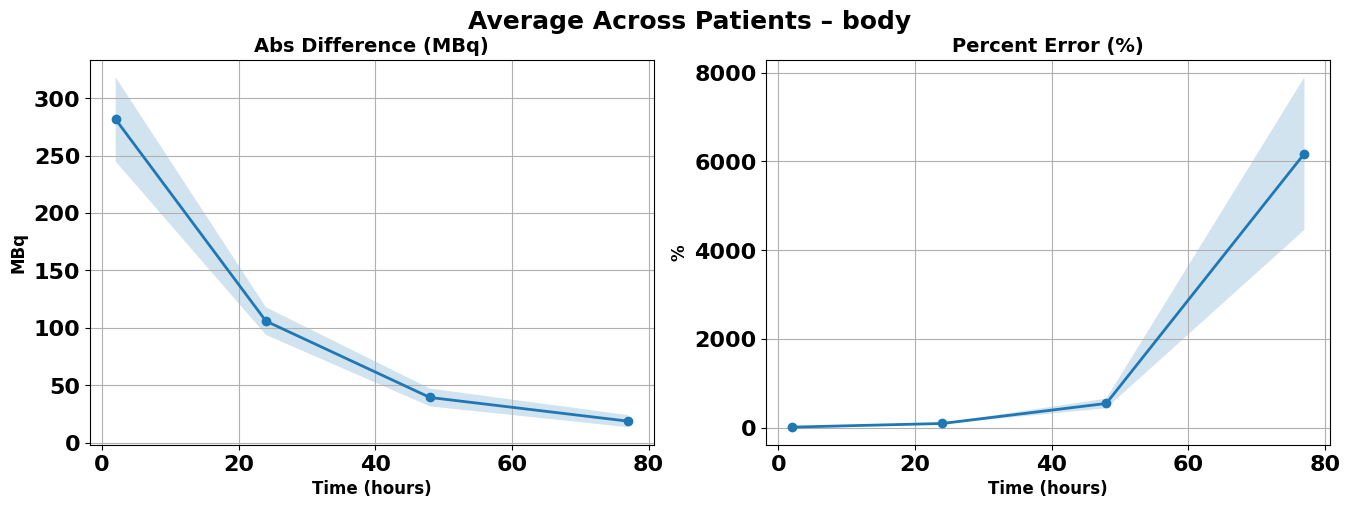

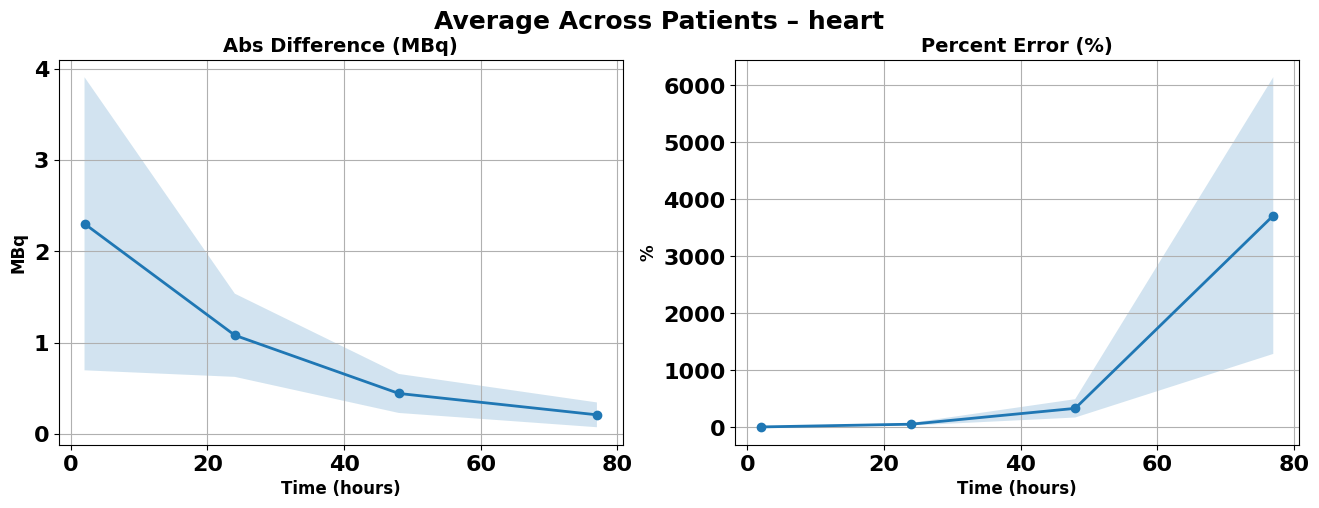

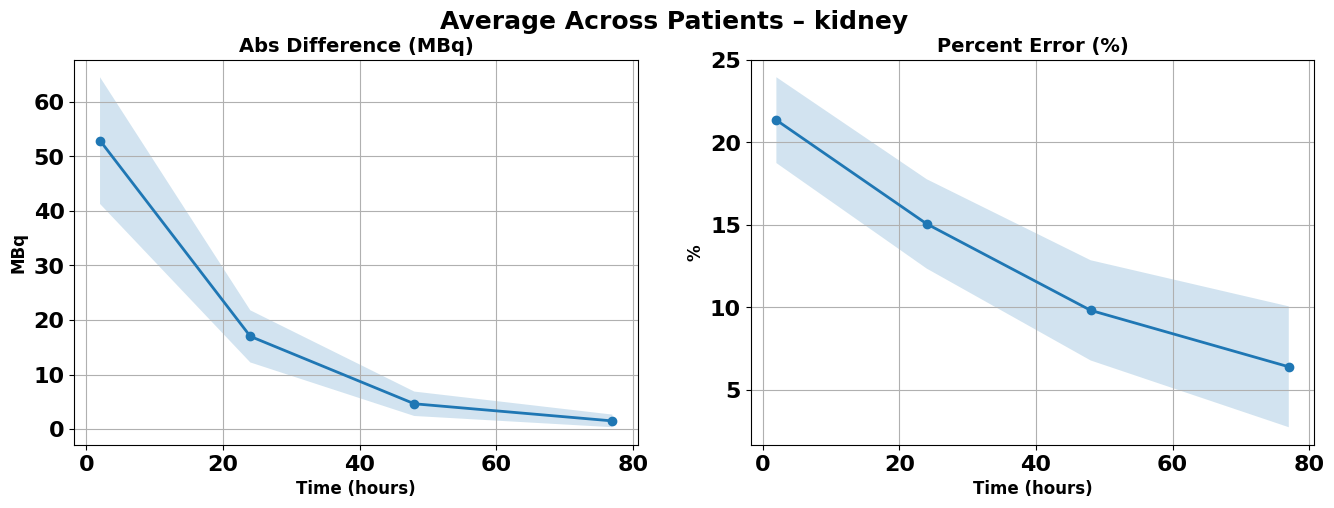

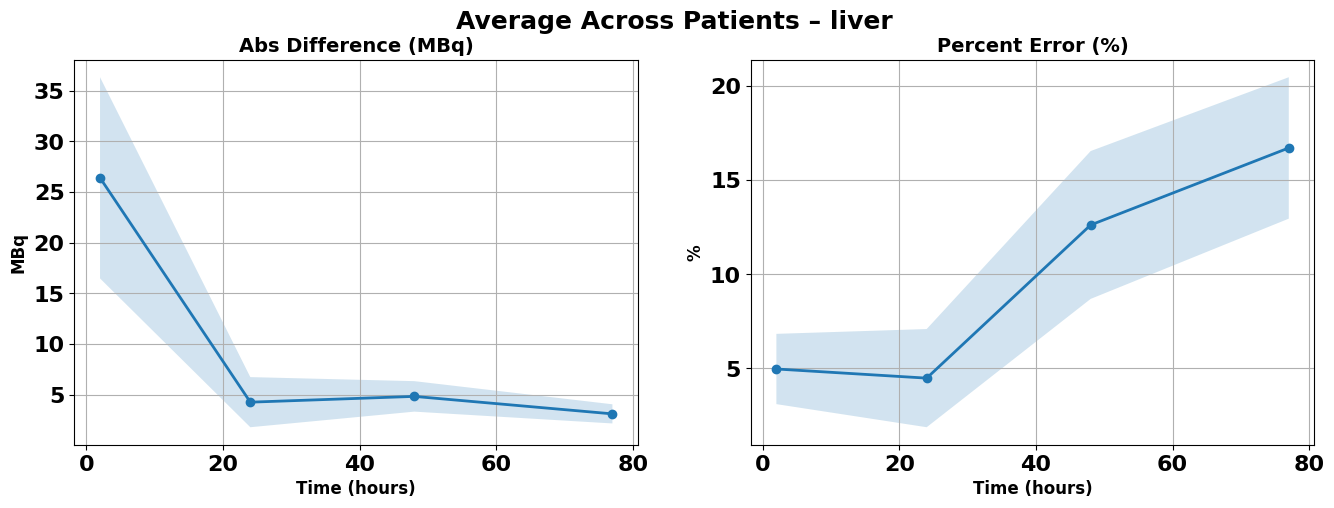

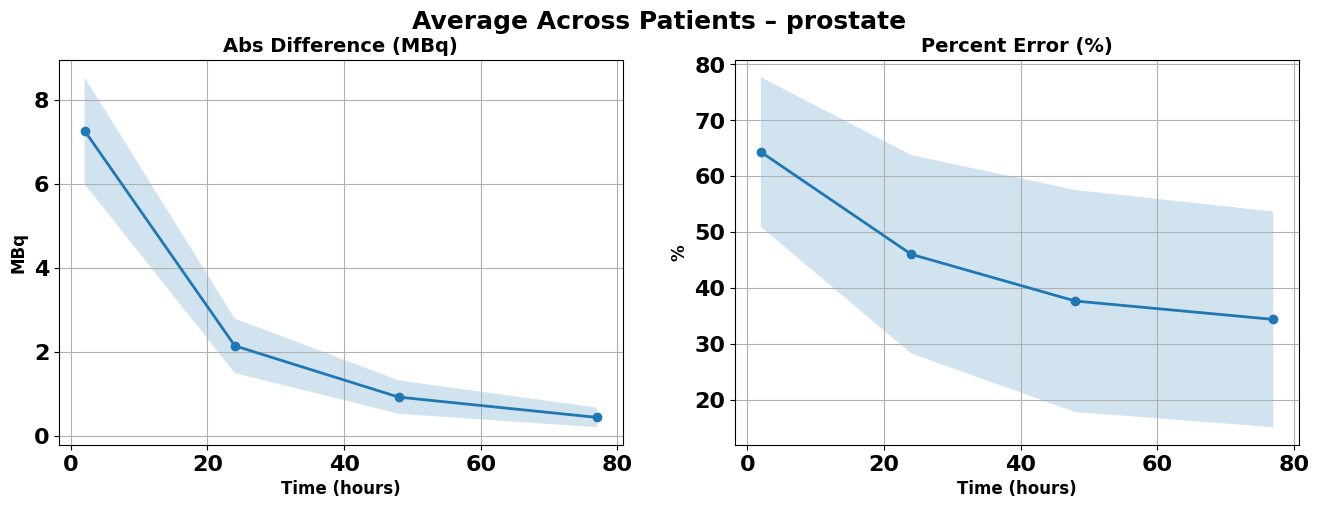

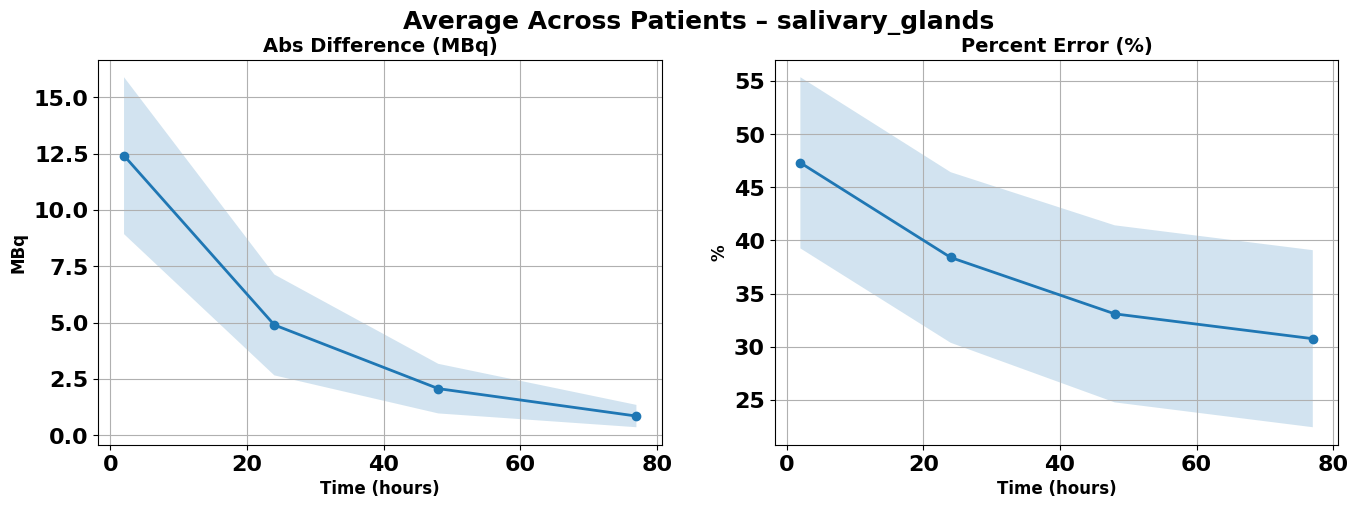

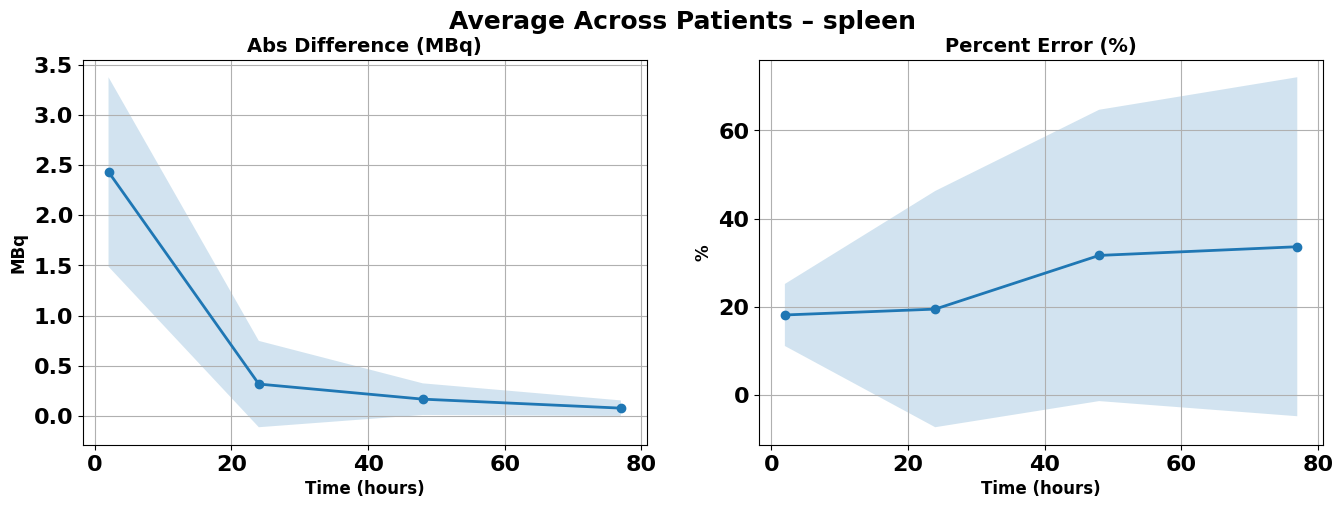

In [67]:
skip_roi = []  
skip_last_frame = True   #blows up               

with open(config_files[0], encoding="utf-8") as f:
    config0 = json.loads(json_minify(f.read()))
frames = list(config0["pbpk"]["FrameStartTimes"])
if skip_last_frame:
    frames = frames[:-1]
t_spect_hr = np.array([f / 60.0 for f in frames], dtype=float)

roi_sets = []
for i in range(len(output_folders)):
    roi_sets.append(set(differences_tac[i].keys()))
common_rois = set.intersection(*roi_sets)
common_rois = sorted([r.lower() for r in common_rois if r.lower() not in skip_roi])

print("ROIs to plot:", common_rois)

avg_diff = {}   # roi -> (n_frames,) mean abs difference MBq
avg_err  = {}   # roi -> (n_frames,) mean % error
std_diff = {}   # roi -> (n_frames,) std
std_err  = {}   # roi -> (n_frames,) std 

n_patients = len(output_folders)
n_frames = len(frames)

for roi in common_rois:
    diff_stack = np.full((n_patients, n_frames), np.nan, dtype=float) 
    err_stack  = np.full((n_patients, n_frames), np.nan, dtype=float)

    for p in range(n_patients):
        d = np.asarray(differences_tac[p][roi], dtype=float)
        e = np.asarray(error_percentage_tac[p][roi], dtype=float)

        # enforce same frame length and apply skip_last_frame
        d = d[:n_frames]
        e = e[:n_frames]

        diff_stack[p, :] = np.abs(d)   # absolute difference 
        err_stack[p, :]  = e

    avg_diff[roi] = np.nanmean(diff_stack, axis=0)
    avg_err[roi]  = np.nanmean(err_stack, axis=0)
    std_diff[roi] = np.nanstd(diff_stack, axis=0)
    std_err[roi]  = np.nanstd(err_stack, axis=0)

# ---- plot per ROI (one figure per ROI): left = abs diff, right = % error ----
for roi in common_rois:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f"Average Across Patients – {roi}", fontsize=18, fontweight="bold")

    # Absolute differences
    axes[0].plot(t_spect_hr, avg_diff[roi], marker="o", linewidth=2)
    axes[0].fill_between(
        t_spect_hr,
        avg_diff[roi] - std_diff[roi],
        avg_diff[roi] + std_diff[roi],
        alpha=0.2
    )
    axes[0].set_title("Abs Difference (MBq)", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Time (hours)", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("MBq", fontsize=12, fontweight="bold")
    axes[0].grid(True)

    # Percentage errors
    axes[1].plot(t_spect_hr, avg_err[roi], marker="o", linewidth=2)
    axes[1].fill_between(
        t_spect_hr,
        avg_err[roi] - std_err[roi],
        avg_err[roi] + std_err[roi],
        alpha=0.2
    )
    axes[1].set_title("Percent Error (%)", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Time (hours)", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("%", fontsize=12, fontweight="bold")
    axes[1].grid(True)

    plt.show()


## Comparison 2) Observing kinetics of SPECT TAC Curve (PBPK TAC parameters inlcuded)

#### Applying Bi-Exponential Fit  + Find Parameters  

In [68]:
def biexp_through_origin(t, A, k_slow, delta):
    """
    y(t) = A*(exp(-k_slow*t) - exp(-(k_slow+delta)*t))
    - y(0)=0 always
    - k_fast = k_slow + delta >= k_slow
    """
    t = np.asarray(t, dtype=float)
    k_fast = k_slow + delta
    return A * (np.exp(-k_slow*t) - np.exp(-k_fast*t))

def _fit_biexp_through_origin(t, y):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    mask = np.isfinite(t) & np.isfinite(y)
    t_fit = t[mask]
    y_fit = y[mask]

    if t_fit.size < 3:
        raise ValueError(f"Need >= 3 points for through-origin biexp (got {t_fit.size}).")

    Amax = float(np.max(y_fit))
    # reasonable initial guesses (t in hours)
    p0 = [Amax, 0.05, 1.0]  # A, k_slow, delta  (1/hr)
    bounds = ([0.0, 0.0, 0.0], [np.inf, np.inf, np.inf])

    popt, pcov = curve_fit(
        biexp_through_origin, t_fit, y_fit,
        p0=p0, bounds=bounds, maxfev=50000
    )

    yhat = biexp_through_origin(t_fit, *popt)
    rmse = float(np.sqrt(np.mean((yhat - y_fit)**2)))
    return popt, pcov, rmse, t_fit, y_fit

In [73]:
show_plot = False 
show_results = False
 
fit_results = {}  # {patient_idx: {roi: {"pbpk":..., "spect":...}}}


for i, output_folder in enumerate(output_folders):
    with open(config_files[i], encoding="utf-8") as f:
        config = json.loads(json_minify(f.read()))
    frames = list(config["pbpk"]["FrameStartTimes"])
    t_spect_hr = np.asarray(frames, dtype=float) / 60.0  # hours

    spect_tac = sim_spect_tacs[i]  # {roi: {"sum_mbq": ...}}
    pbpk_tac = pbpk_tacs[i]        # {roi: {"t":..., "act":..., ...}}

    rois = list(spect_tac.keys())
    rois = [r.lower() for r in rois]  # normalize

    fit_results[i] = {}

    if show_plot:
        n = len(rois)
        fig, axes = plt.subplots(2, n, figsize=(5 * n, 16), constrained_layout=True)
        fig.suptitle(
            f"Patient {i+1} Bi-exponential (through origin) Fits: PBPK (top) vs SPECT (bottom)",
            fontsize=24, fontweight="bold"
        )
        axes = np.array(axes)

    for j, roi_key in enumerate(rois):
        # ---------- PBPK ----------
        t_pbpk_hr = np.asarray(pbpk_tac[roi_key]["t"], dtype=float) / 60.0
        y_pbpk = np.asarray(pbpk_tac[roi_key]["act"], dtype=float)

        popt_pbpk, pcov_pbpk, rmse_pbpk, _, _ = _fit_biexp_through_origin(t_pbpk_hr, y_pbpk)
        tgrid_pbpk = np.linspace(0.0, np.nanmax(t_pbpk_hr), 400)
        ygrid_pbpk = biexp_through_origin(tgrid_pbpk, *popt_pbpk)

        # ---------- SPECT ----------
        y_spect = np.asarray(spect_tac[roi_key]["sum_mbq"], dtype=float)

        popt_spect, pcov_spect, rmse_spect, _, _ = _fit_biexp_through_origin(t_spect_hr, y_spect)
        tgrid_spect = np.linspace(0.0, np.nanmax(t_spect_hr), 400)
        ygrid_spect = biexp_through_origin(tgrid_spect, *popt_spect)
            
        # store results
        fit_results[i][roi_key] = {
            "pbpk": {"popt": popt_pbpk, "pcov": pcov_pbpk, "rmse": rmse_pbpk},
            "spect": {"popt": popt_spect, "pcov": pcov_spect, "rmse": rmse_spect},
        }

        # plot
        if show_plot:
            ax = axes[0, j]
            ax.plot(t_pbpk_hr, y_pbpk, linestyle="None", marker="o", markersize=6, label=f"{roi_key} (PBPK)")
            ax.plot(tgrid_pbpk, ygrid_pbpk, linewidth=3, label="Bi-exp fit")
            ax.set_title(f"PBPK | ROI: {roi_key}\nRMSE={rmse_pbpk:.3g}")
            ax.set_xlabel("Time [hrs]")
            ax.set_ylabel("Total Activity (MBq)")
            ax.grid(True)
            ax.legend()

            ax = axes[1, j]
            ax.scatter(t_spect_hr, y_spect, s=100, marker="x", label=f"{roi_key} (SPECT)")
            ax.plot(tgrid_spect, ygrid_spect, linewidth=3, label="Bi-exp fit")
            ax.set_title(f"SPECT | ROI: {roi_key}\nRMSE={rmse_spect:.3g}")
            ax.set_xlabel("Time [hrs]")
            ax.set_ylabel("Total Activity (MBq)")
            ax.grid(True)
            ax.legend()

    if show_plot:
        plt.show()


if show_results:
    print("Bi-exponential Fit Results:")
    for i in fit_results:
        print(f"\nPatient {i+1}:")
        for roi in fit_results[i]:
            pb = fit_results[i][roi]["pbpk"]["popt"]
            sp = fit_results[i][roi]["spect"]["popt"]
            A_pb, kslow_pb, delta_pb = pb
            A_sp, kslow_sp, delta_sp = sp
            print(f"  {roi}: PBPK kslow={kslow_pb:.4g}, kfast={kslow_pb+delta_pb:.4g} | "
                f"SPECT kslow={kslow_sp:.4g}, kfast={kslow_sp+delta_sp:.4g}")


### ---Final results for Difference and Error Percentage for Case 2---

In [74]:
show_results = True         
skip_roi = []           


def _diff_and_pct(spect_val, pbpk_val, eps=1e-9):
    diff = float(spect_val - pbpk_val)
    pct  = float(np.abs(diff) / (np.abs(pbpk_val) + eps) * 100.0) # percentage error, add small value to avoid div by zero
    return diff, pct

param_errors = {}   # {patient_idx: {roi: {"k_slow": {...}, "k_fast": {...}}}}
acc = {}            # {roi: {"k_slow_diff":[], "k_slow_pct":[], "k_fast_diff":[], "k_fast_pct":[]}}

for i in fit_results:
    param_errors[i] = {}
    for roi in fit_results[i]:
        roi_l = roi.lower()
        if roi_l in skip_roi:
            continue

        pb = fit_results[i][roi]["pbpk"]["popt"]
        sp = fit_results[i][roi]["spect"]["popt"]

        # unpack
        A_pb, kslow_pb, delta_pb = [float(x) for x in pb]
        A_sp, kslow_sp, delta_sp = [float(x) for x in sp]

        kfast_pb = kslow_pb + delta_pb
        kfast_sp = kslow_sp + delta_sp

        # differences: (SPECT - PBPK) and %error relative to PBPK
        kslow_diff, kslow_pct = _diff_and_pct(kslow_sp, kslow_pb)
        kfast_diff, kfast_pct = _diff_and_pct(kfast_sp, kfast_pb)

        param_errors[i][roi_l] = {
            "k_slow": {"pbpk": kslow_pb, "spect": kslow_sp, "diff": kslow_diff, "pct_err": kslow_pct},
            "k_fast": {"pbpk": kfast_pb, "spect": kfast_sp, "diff": kfast_diff, "pct_err": kfast_pct},
        }

        if roi_l not in acc:
            acc[roi_l] = {"k_slow_diff": [], "k_slow_pct": [], "k_fast_diff": [], "k_fast_pct": []}
        acc[roi_l]["k_slow_diff"].append(kslow_diff)
        acc[roi_l]["k_slow_pct"].append(kslow_pct)
        acc[roi_l]["k_fast_diff"].append(kfast_diff)
        acc[roi_l]["k_fast_pct"].append(kfast_pct)

# ----------------- print per-patient condensed -----------------
if show_results:
    print("Parameter differences: SPECT - PBPK (and %error vs PBPK)")
    for i in sorted(param_errors.keys()):
        print(f"\nPatient {i+1}:")
        for roi in sorted(param_errors[i].keys()):
            ks = param_errors[i][roi]["k_slow"]
            kf = param_errors[i][roi]["k_fast"]
            print(f"  {roi:16s}  k_slow Δ={ks['diff']:+.3g} ({ks['pct_err']:.2g}%) | "
                  f"k_fast Δ={kf['diff']:+.3g} ({kf['pct_err']:.2g}%)")

# ----------------- ROI averages across patients (condensed) -----------------
roi_param_avg = {}   # {roi: {"k_slow": {...}, "k_fast": {...}}}

def _mean_std(x):
    x = np.asarray(x, dtype=float)
    return float(np.mean(x)), float(np.std(x)), int(x.size)

if show_results:
    print("\nAcross-patient ROI averages (mean ± std):")
    for roi in sorted(acc.keys()):
        m_d, s_d, n = _mean_std(acc[roi]["k_slow_diff"])
        m_p, s_p, _ = _mean_std(acc[roi]["k_slow_pct"])
        m_df, s_df, _ = _mean_std(acc[roi]["k_fast_diff"])
        m_pf, s_pf, _ = _mean_std(acc[roi]["k_fast_pct"])

        roi_param_avg[roi] = {
            "n": n,
            "k_slow": {"diff_mean": m_d, "diff_std": s_d, "pct_mean": m_p, "pct_std": s_p},
            "k_fast": {"diff_mean": m_df, "diff_std": s_df, "pct_mean": m_pf, "pct_std": s_pf},
        }

        print(f"  {roi:16s} n={n:2d} | "
              f"k_slow Δ={m_d:+.3g}±{s_d:.2g} ({m_p:.2g}±{s_p:.2g}%) | "
              f"k_fast Δ={m_df:+.3g}±{s_df:.2g} ({m_pf:.2g}±{s_pf:.2g}%)")


Parameter differences: SPECT - PBPK (and %error vs PBPK)

Patient 1:
  body              k_slow Δ=-0.0274 (22%) | k_fast Δ=+15.3 (6.6e+02%)
  heart             k_slow Δ=-0.0489 (32%) | k_fast Δ=-1.15e+03 (98%)
  kidney            k_slow Δ=-0.00327 (9.1%) | k_fast Δ=+2.71 (32%)
  liver             k_slow Δ=-0.0247 (26%) | k_fast Δ=-1.46e+03 (94%)
  prostate          k_slow Δ=-0.0106 (33%) | k_fast Δ=+4.67 (93%)
  salivary_glands   k_slow Δ=-0.00364 (11%) | k_fast Δ=+8.64 (4.3e+02%)
  spleen            k_slow Δ=-0.0521 (39%) | k_fast Δ=-1.1e+03 (99%)

Patient 2:
  body              k_slow Δ=-0.0296 (24%) | k_fast Δ=+15.9 (6.6e+02%)
  heart             k_slow Δ=-0.0465 (30%) | k_fast Δ=-1.13e+03 (98%)
  kidney            k_slow Δ=-0.00352 (10%) | k_fast Δ=+3.99 (33%)
  liver             k_slow Δ=-0.0236 (26%) | k_fast Δ=-2.45e+03 (99%)
  prostate          k_slow Δ=-0.00545 (21%) | k_fast Δ=+5.53 (1e+02%)
  salivary_glands   k_slow Δ=-0.00308 (11%) | k_fast Δ=-0.108 (14%)
  spleen         

## Comparison 3) Area Under Curve (AUC) - Using Fit Data

In [75]:
show_results = False
skip_roi = []          

# ----------------- numeric AUC from fit params -----------------
def auc_from_fit(popt, t_end_hr, n=5000):
    """Trapezoid AUC of biexp_through_origin from 0..t_end_hr (hours)."""
    A, k_slow, delta = [float(x) for x in popt]
    t = np.linspace(0.0, float(t_end_hr), int(n))
    y = biexp_through_origin(t, A, k_slow, delta)
    return float(np.trapezoid(y, t))  # units: (MBq * hr)

# ----------------- compute AUCs for each patient/ROI -----------------
auc_results = {}  # {patient_idx: {roi: {"t_end_hr":..., "pbpk_auc":..., "spect_auc":...}}}

for i in fit_results:
    # use patient-specific t_end (defaults to max frame time)
    with open(config_files[i], encoding="utf-8") as f:
        cfg = json.loads(json_minify(f.read()))
    frames = np.asarray(cfg["pbpk"]["FrameStartTimes"], dtype=float) / 60.0  # hr
    t_end = float(np.max(frames)) 

    auc_results[i] = {}

    for roi in fit_results[i]:
        roi_l = roi.lower()
        if roi_l in skip_roi:
            continue

        pb = fit_results[i][roi]["pbpk"]["popt"]
        sp = fit_results[i][roi]["spect"]["popt"]

        pb_auc = auc_from_fit(pb, t_end)
        sp_auc = auc_from_fit(sp, t_end)

        auc_results[i][roi_l] = {
            "t_end_hr": t_end,
            "pbpk_auc_mbq_hr": pb_auc,
            "spect_auc_mbq_hr": sp_auc,
        }

# ----------------- pretty print table (per patient) -----------------
if show_results:
    for i in sorted(auc_results.keys()):
        rois = sorted(auc_results[i].keys())
        if len(rois) == 0:
            continue

        t_end = auc_results[i][rois[0]]["t_end_hr"]
        print(f"\nPatient {i+1}  |  AUC from fit (0 → {t_end:.2f} hr)")
        print(f"{'ROI':16s} {'PBPK_AUC':>12s} {'SPECT_AUC':>12s} |  units: MBq·hr")
        print("-" * 64)

        for roi in rois:
            row = auc_results[i][roi]
            print(f"{roi:16s} "
                  f"{row['pbpk_auc_mbq_hr']:12.4g} "
                  f"{row['spect_auc_mbq_hr']:12.4g} ")


### Final results for Difference and Error Percentage for Case 3

In [76]:
show_results = True
skip_roi = []   # e.g. ["body"]

auc_diff = {}   # {patient_idx: {roi: {"diff_mbq_hr":..., "pct_err":...}}}
roi_acc  = {}   # {roi: {"diff":[], "pct":[]} }

# -------- per-patient diffs + accumulate for averages --------
for i in sorted(auc_results.keys()):
    auc_diff[i] = {}

    for roi in auc_results[i]:
        roi_l = roi.lower()
        if roi_l in skip_roi:
            continue

        pb = float(auc_results[i][roi]["pbpk_auc_mbq_hr"])
        sp = float(auc_results[i][roi]["spect_auc_mbq_hr"])

        diff = sp - pb
        pct  = (abs(diff) / (abs(pb) + 1e-9)) * 100.0

        auc_diff[i][roi_l] = {"diff_mbq_hr": diff, "pct_err": pct}

        if roi_l not in roi_acc:
            roi_acc[roi_l] = {"diff": [], "pct": []}
        roi_acc[roi_l]["diff"].append(diff)
        roi_acc[roi_l]["pct"].append(pct)

# -------- print per-patient table --------
if show_results:
    for i in sorted(auc_diff.keys()):
        print(f"\nPatient {i+1} — AUC (fit) SPECT vs PBPK")
        header = f"{'ROI':16s} {'Δ(S-P) (MBq·hr)':>16s} {'%Err':>10s}"
        print(header)
        print("-" * len(header))

        for roi in sorted(auc_diff[i].keys()):
            d = auc_diff[i][roi]["diff_mbq_hr"]
            p = auc_diff[i][roi]["pct_err"]
            print(f"{roi:16s} {d:+16.4g} {p:10.3g}")

# -------- print averages across patients --------
if show_results:
    print("\nAUC (fit) SPECT vs PBPK — average across patients")
    header = f"{'ROI':16s} {'Δ(S-P) mean':>14s} {'Δ std':>12s} {'%Err mean':>12s} {'%Err std':>10s} {'n':>3s}"
    print(header)
    print("-" * len(header))

    for roi in sorted(roi_acc.keys()):
        diffs = np.asarray(roi_acc[roi]["diff"], dtype=float)
        pcts  = np.asarray(roi_acc[roi]["pct"], dtype=float)

        d_mean = diffs.mean()
        d_std  = diffs.std()
        p_mean = pcts.mean()
        p_std  = pcts.std()
        n      = diffs.size

        print(f"{roi:16s} "
              f"{d_mean:+14.4g} {d_std:12.2g} "
              f"{p_mean:12.3g} {p_std:10.2g} "
              f"{n:3d}")



Patient 1 — AUC (fit) SPECT vs PBPK
ROI               Δ(S-P) (MBq·hr)       %Err
--------------------------------------------
body                        +7638       51.2
heart                      +17.44        5.9
kidney                      -1388       13.3
liver                      +751.6       10.3
prostate                   -192.3       56.4
salivary_glands            -240.1       27.9
spleen                     -7.624       5.03

Patient 2 — AUC (fit) SPECT vs PBPK
ROI               Δ(S-P) (MBq·hr)       %Err
--------------------------------------------
body                        +8249       55.5
heart                      +9.034       3.07
kidney                      -1676         20
liver                       +1135       15.1
prostate                   -129.3       29.1
salivary_glands            -753.3       42.1
spleen                     +29.19         19

Patient 3 — AUC (fit) SPECT vs PBPK
ROI               Δ(S-P) (MBq·hr)       %Err
----------------------------------